In [2]:
import math
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns

In [3]:
# Makes figures with white background
sns.set_style("whitegrid")
%matplotlib inline

## Functions

In [3]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether you need to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [4]:
def volcano(df, significantdf, foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=50, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [5]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 AKI')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Control')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [6]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [7]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [8]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

## Data Normalization 

In [63]:
df = pd.read_csv('QF149.csv')
df

,Unnamed: 0,Protein,Description,Checked,Confidence,Identifying.Node,PSM.Ambiguity,Annotated.Sequence,Modifications,X..Protein.Groups,...,Area..F16..Sample,Area..F17..Sample,Area..F18..Sample,Area..F19..Sample,Area..F20..Sample,Area..F21..Sample,Area..F22..Sample,emPAI,Score.Sequest.HT,X..Peptides.Sequest.HT
0,229,P01024,Complement C3 OS=Homo sapiens GN=C3 PE=1 SV=2,False,High,Sequest HT (A2),Unambiguous,SGSDEVQVGQQR,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,821,P26038,Moesin OS=Homo sapiens GN=MSN PE=1 SV=3,False,High,Sequest HT (A2),Unambiguous,AQmVQEDLEK,M3(Oxidation),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,912,P26038,Moesin OS=Homo sapiens GN=MSN PE=1 SV=3,False,High,Sequest HT (A2),Unambiguous,VTAQDVR,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,918,P26038,Moesin OS=Homo sapiens GN=MSN PE=1 SV=3,False,High,Sequest HT (A2),Unambiguous,AmLENEK,M2(Oxidation),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,928,P26038,Moesin OS=Homo sapiens GN=MSN PE=1 SV=3,False,High,Sequest HT (A2),Unambiguous,SGYLAGDK,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,931,P26038,Moesin OS=Homo sapiens GN=MSN PE=1 SV=3,False,High,Sequest HT (A2),Unambiguous,AmLENEK,M2(Oxidation),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1070,P04264,"Keratin, type II cytoskeletal 1 OS=Homo sapien...",False,High,Sequest HT (A2),Unambiguous,WELLQQVDTSTR,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1071,P04264,"Keratin, type II cytoskeletal 1 OS=Homo sapien...",False,High,Sequest HT (A2),Unambiguous,SLNNQFASFIDK,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1074,P04264,"Keratin, type II cytoskeletal 1 OS=Homo sapien...",False,High,Sequest HT (A2),Unambiguous,QISNLQQSISDAEQR,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1079,P04264,"Keratin, type II cytoskeletal 1 OS=Homo sapien...",False,High,Sequest HT (A2),Unambiguous,NmQDmVEDYR,M2(Oxidation); M5(Oxidation),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
#Goal is to sum the signal from the different TMT reagents
#Also need to convert some of the values to numeric values from characters.
columns =  ['Area','Protein']
df = df[columns]
df_summed = df[['Area']].groupby([df.Protein]).agg(['sum'])
df_summed = df_summed.rename(columns={'Area' : 'QF149'})
df_summed

,QF149
,sum
Protein,
A0A024R571,2.324261e+06
A0A024R6I7,7.378400e+06
A0A0A0MT26,8.998703e+05
A0A0B4J231,1.157432e+05
A0A0G2JIW1,2.715614e+06
A0A0G2JMB2,1.006064e+06
A8MXZ4,2.122939e+05
E7EQR4,3.788038e+07


In [32]:
#First merge
samples = ['NR_2','NR_4']
alldf = NR_2.merge(NR_4, left_index = True, right_index = True, suffixes = samples, how = 'outer')
alldf

,AreaNR_2,AreaNR_4
,sum,sum
Protein,,
A0A024R571,3.123760e+06,NaN
A0A024R6I7,2.194147e+07,NaN
A0A096LPE2,7.594432e+05,NaN
A0A0A0MS08,3.949870e+07,2.060763e+06
A0A0A0MT26,2.409561e+07,NaN
A0A0A0MTS2,9.664256e+05,NaN
A0A0B4J1T8,2.598076e+06,NaN
A0A0B4J231,8.865546e+06,NaN


In [65]:
#All other merges
alldf2 = alldf2.merge(df_summed, left_index = True, right_index = True, how = 'outer')
alldf2

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,QF146,QF149
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
Protein,,,,,,,,,,,,
A0A024R0K5,NaN,NaN,NaN,NaN,NaN,NaN,7.451974e+06,NaN,NaN,NaN,NaN,NaN
A0A024R4E5,NaN,NaN,NaN,NaN,NaN,NaN,1.885318e+07,NaN,NaN,NaN,NaN,NaN
A0A024R571,3.123760e+06,NaN,NaN,NaN,5.457764e+06,NaN,2.851086e+09,NaN,NaN,NaN,6.537175e+05,2.324261e+06
A0A024R6I7,2.194147e+07,NaN,1.244946e+07,NaN,1.805281e+07,NaN,9.227391e+09,8.701904e+06,3.179513e+06,NaN,3.797741e+06,7.378400e+06
A0A044PY82,NaN,NaN,NaN,NaN,NaN,NaN,5.801136e+06,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,NaN,NaN,NaN,NaN,NaN,NaN,6.185622e+08,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,1.525827e+08,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,1.674687e+08,NaN,NaN,NaN,NaN,NaN


In [82]:
alldf2.to_csv('all_proteins_summed.csv')

In [66]:
df_summed = alldf2

In [67]:
#First Normalization step
#Value/(Protein Average/Median of Protein Averages)
df_summed.columns = df_summed.columns.droplevel(level=1)
col_list = list(df_summed)

In [104]:
df_summed['Protein_Average'] = df_summed[col_list].mean(axis=1)
Protein_Average_Median = df_summed['Protein_Average'].median()

AttributeError: 'Series' object has no attribute 'nanmedian'

In [75]:
for i in col_list:
    df_summed['%s_adj1' % i] = df_summed['%s' % i]/(df_summed.Protein_Average/Protein_Average_Median)
    

In [77]:
df_summed.columns

Index(['NR_2', 'NR_4', 'PN0233', 'PN0414', 'PN0429', 'PN0533', 'PN0842',
       'QF110', 'QF113', 'QF120', 'QF146', 'QF149', 'Protein_Average',
       'NR_2_adj1', 'NR_4_adj1', 'PN0233_adj1', 'PN0414_adj1', 'PN0429_adj1',
       'PN0533_adj1', 'PN0842_adj1', 'QF110_adj1', 'QF113_adj1', 'QF120_adj1',
       'QF146_adj1', 'QF149_adj1'],
      dtype='object')

In [84]:
cols = list(df_summed)
for i in col_list:
    cols.remove(i)
cols.remove('Protein_Average')
cols

['NR_2_adj1',
 'NR_4_adj1',
 'PN0233_adj1',
 'PN0414_adj1',
 'PN0429_adj1',
 'PN0533_adj1',
 'PN0842_adj1',
 'QF110_adj1',
 'QF113_adj1',
 'QF120_adj1',
 'QF146_adj1',
 'QF149_adj1']

In [115]:
Overall_Median = np.nanmedian(df_summed[cols])
Overall_Median

49003008.380000003

In [116]:
for i in col_list:
    df_summed['%s_adj2' % i] = df_summed['%s_adj1' % i]/(df_summed['%s_adj1' % i].median()/Overall_Median)

In [120]:
cols2 = list(df_summed)
for i in col_list:
    cols2.remove(i)
cols2.remove('Protein_Average')
for i in cols:
    cols2.remove(i)
cols2

['NR_2_adj2',
 'NR_4_adj2',
 'PN0233_adj2',
 'PN0414_adj2',
 'PN0429_adj2',
 'PN0533_adj2',
 'PN0842_adj2',
 'QF110_adj2',
 'QF113_adj2',
 'QF120_adj2',
 'QF146_adj2',
 'QF149_adj2']

In [121]:
df2 = df_summed[cols2]
df2

,NR_2_adj2,NR_4_adj2,PN0233_adj2,PN0414_adj2,PN0429_adj2,PN0533_adj2,PN0842_adj2,QF110_adj2,QF113_adj2,QF120_adj2,QF146_adj2,QF149_adj2
Protein,,,,,,,,,,,,
A0A024R0K5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R4E5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R571,1.293303e+07,NaN,NaN,NaN,3.227276e+07,NaN,2.440257e+08,NaN,NaN,NaN,2.190263e+06,1.698395e+07
A0A024R6I7,4.472579e+07,NaN,2.288361e+07,NaN,5.255764e+07,NaN,3.888424e+08,8.966972e+06,6.298025e+06,NaN,6.264711e+06,2.654517e+07
A0A044PY82,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6K0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN


In [122]:
for i in col_list:
    df2 = df2.rename(columns={'%s_adj2' % i:'%s' % i})
df2

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,QF146,QF149
Protein,,,,,,,,,,,,
A0A024R0K5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R4E5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R571,1.293303e+07,NaN,NaN,NaN,3.227276e+07,NaN,2.440257e+08,NaN,NaN,NaN,2.190263e+06,1.698395e+07
A0A024R6I7,4.472579e+07,NaN,2.288361e+07,NaN,5.255764e+07,NaN,3.888424e+08,8.966972e+06,6.298025e+06,NaN,6.264711e+06,2.654517e+07
A0A044PY82,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6K0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN


In [123]:
df2.to_csv('Normlized_proteins.csv')

## Analysis

In [9]:
df2 = pd.read_csv('Normlized_proteins.csv', index_col="Protein")

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,QF146,QF149
Protein,,,,,,,,,,,,
A0A024R0K5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R4E5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A024R571,1.293303e+07,NaN,NaN,NaN,3.227276e+07,NaN,2.440257e+08,NaN,NaN,NaN,2.190263e+06,1.698395e+07
A0A024R6I7,4.472579e+07,NaN,2.288361e+07,NaN,5.255764e+07,NaN,3.888424e+08,8.966972e+06,6.298025e+06,NaN,6.264711e+06,2.654517e+07
A0A044PY82,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN
A0A075B6K0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN


In [10]:
#Drop the outlier if wanted
df2 = df2.drop("PN0842", axis=1)

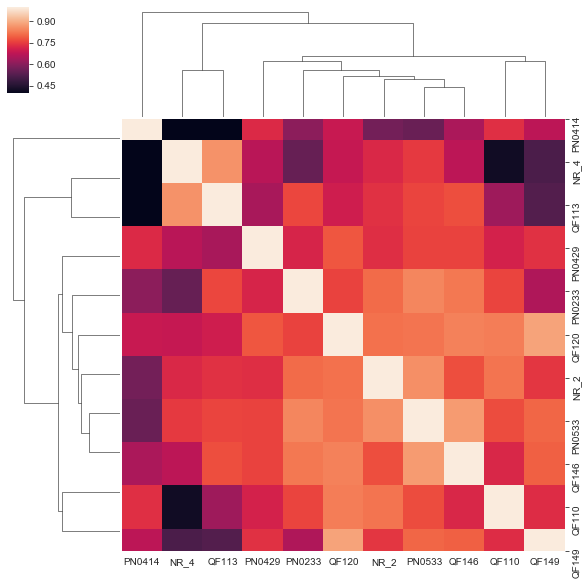

In [11]:
corr = df2.corr(method='spearman')
sns.clustermap(corr)
plt.savefig('Spearman_correlation_heatmap_nooutlier.pdf')

In [25]:
#Disease = ['PN0233', 'PN0414', 'PN0429', 'PN0533', 'PN0842']
#Drop outlier if desired
Disease = ['PN0233', 'PN0414', 'PN0429', 'PN0533']
Control = ['NR_2', 'NR_4','QF110', 'QF113', 'QF120', 'QF146', 'QF149']

In [26]:
Disease_df = df2[Disease]
Control_df = df2[Control]

In [27]:
TwoCategoryMaster(df2,Disease_df,Control_df,"AKI","Control")

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,QF146,QF149,ttest_pvalue,AKI Mean,Control Mean,Fold Change(AKI/Control),Log2(Fold Change),-Log(P-value),AKI/Control pi score
Protein,,,,,,,,,,,,,,,,,,,
A0A024R0K5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024R4E5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024R571,1.293303e+07,NaN,NaN,NaN,3.227276e+07,NaN,2.440257e+08,NaN,NaN,NaN,2.190263e+06,1.698395e+07,NaN,3.227276e+07,1.070242e+07,3.015465,1.592381,NaN,NaN
A0A024R6I7,4.472579e+07,NaN,2.288361e+07,NaN,5.255764e+07,NaN,3.888424e+08,8.966972e+06,6.298025e+06,NaN,6.264711e+06,2.654517e+07,0.396125,3.772062e+07,1.856014e+07,2.032346,1.023146,0.402168,0.411477
A0A044PY82,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6K0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
top10 = df2['AKI/Control pi score'].nlargest(10)
low10 = df2['AKI/Control pi score'].nsmallest(10)

top10df = df2[df2['AKI/Control pi score'].isin(top10)]
low10df = df2[df2['AKI/Control pi score'].isin(low10)]

In [29]:
#Subset out the significant proteins to a new dataframe
df_sign= df2[(abs(df2['AKI/Control pi score']) > (1))]

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,QF146,QF149,ttest_pvalue,AKI Mean,Control Mean,Fold Change(AKI/Control),Log2(Fold Change),-Log(P-value),AKI/Control pi score
Protein,,,,,,,,,,,,,,,,,,,
A0A0G2JIW1,7.173742e+07,NaN,7.700182e+05,3.682177e+06,4.777703e+06,NaN,4.850629e+08,8.512237e+05,7.882218e+06,1.704555e+06,1.158644e+08,1.245244e+07,0.161860,3.076633e+06,3.508204e+07,0.087698,-3.511309,0.790860,-2.776953
C9JF17,1.810041e+08,NaN,5.949771e+06,NaN,7.957427e+06,NaN,2.409348e+08,NaN,NaN,NaN,3.396315e+06,NaN,0.512997,6.953599e+06,9.220022e+07,0.075418,-3.728938,0.289885,-1.080963
E9PK54,1.408818e+07,NaN,2.165604e+06,NaN,2.278900e+06,4.427875e+05,3.902172e+08,NaN,6.807791e+06,1.472206e+06,4.884543e+07,NaN,0.226666,1.629097e+06,1.780340e+07,0.091505,-3.450008,0.644614,-2.223924
I3L504,6.385769e+07,NaN,1.911400e+07,NaN,NaN,5.068931e+07,2.873102e+08,NaN,NaN,9.358977e+07,NaN,1.609577e+08,0.122230,3.490165e+07,1.061351e+08,0.328842,-1.604534,0.912823,-1.464655
P00558,1.067603e+08,NaN,NaN,5.001224e+06,5.234286e+07,NaN,2.879433e+08,NaN,NaN,NaN,6.692220e+07,1.133408e+08,0.153494,2.867204e+07,9.567443e+07,0.299683,-1.738489,0.813909,-1.414971
P00738,6.369626e+06,NaN,1.810907e+06,NaN,4.816181e+05,1.185973e+06,3.916544e+08,1.656438e+05,NaN,2.461942e+06,4.124212e+06,NaN,0.205485,1.159499e+06,3.280356e+06,0.353468,-1.500350,0.687219,-1.031069
P01024,8.461778e+05,9.265960e+02,NaN,NaN,2.277894e+05,4.566157e+04,3.919412e+08,NaN,NaN,1.439401e+04,2.316399e+06,1.014086e+05,0.311533,1.367255e+05,6.558613e+05,0.208467,-2.262109,0.506496,-1.145748
P01834,4.154781e+07,1.825730e+05,1.107200e+07,5.797225e+05,3.471821e+05,5.597350e+06,4.876829e+08,NaN,1.031080e+06,1.778150e+06,3.715231e+07,NaN,0.280472,4.399064e+06,1.633838e+07,0.269247,-1.892997,0.552111,-1.045144
P01861,1.131771e+06,NaN,5.562154e+05,NaN,NaN,5.390415e+05,2.446710e+08,NaN,NaN,NaN,1.158628e+07,NaN,0.466342,5.476284e+05,6.359027e+06,0.086118,-3.537537,0.331295,-1.171968


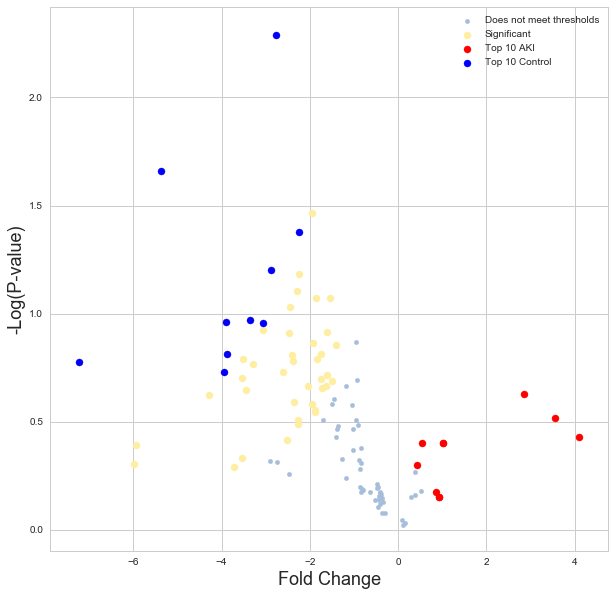

In [33]:
volcanotop10(df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

In [30]:
ann = pd.read_csv('Uniprot_annotations.txt', sep ='\t')

,yourlist:M2018031483C3DD8CE55183C76102DC5D3A26728B0CE68A0,Entry,Entry name,Status,Protein names,Gene names,Length,Gene ontology (GO),Gene ontology (biological process),Gene ontology (molecular function),...,Gene ontology IDs,EC number,Function [CC],Cross-reference (eggNOG),Cross-reference (KO),Cross-reference (OrthoDB),Involvement in disease,Mutagenesis,Tissue specificity,Cross-reference (BioCyc)
0,A0A024R0K5,A0A024R0K5,A0A024R0K5_HUMAN,unreviewed,Carcinoembryonic antigen-related cell adhesion...,CEACAM5 hCG_1642477,702.0,plasma membrane [GO:0005886],NaN,NaN,...,GO:0005886,NaN,NaN,ENOG410IFE1;ENOG410YR1P;,K06499;,EOG091G0AMM;,NaN,NaN,NaN,NaN
1,A0A024R4E5,A0A024R4E5,A0A024R4E5_HUMAN,unreviewed,High density lipoprotein binding protein (Vigi...,HDLBP hCG_33048,1268.0,cytosol [GO:0005829]; RNA binding [GO:0003723],NaN,RNA binding [GO:0003723],...,GO:0003723; GO:0005829,NaN,NaN,KOG2208;ENOG410XQFV;,NaN,EOG091G00NZ;,NaN,NaN,NaN,NaN
2,A0A024R571,A0A024R571,A0A024R571_HUMAN,unreviewed,EH domain-containing protein 1 (EH-domain cont...,EHD1 hCG_23386,548.0,early endosome [GO:0005769]; endocytic vesicle...,cellular response to nerve growth factor stimu...,calcium ion binding [GO:0005509]; GTP binding ...,...,GO:0005509; GO:0005525; GO:0005769; GO:0005811...,NaN,NaN,KOG1954;ENOG410XYGB;,NaN,EOG091G04KA;,NaN,NaN,NaN,NaN
3,A0A024R6I7,A0A024R6I7,A0A024R6I7_HUMAN,unreviewed,Alpha-1-antitrypsin (Serpin peptidase inhibito...,SERPINA1 hCG_2029168,418.0,extracellular space [GO:0005615],NaN,NaN,...,GO:0005615,NaN,NaN,KOG2392;COG4826;,NaN,EOG091G0ION;,NaN,NaN,NaN,NaN
4,A0A044PY82,A0A044PY82,A0A044PY82_HUMAN,unreviewed,Uncharacterized protein MISP3,MISP3,361.0,NaN,NaN,NaN,...,NaN,NaN,NaN,ENOG410IHG4;ENOG4111C5I;,NaN,EOG091G0IC6;,NaN,NaN,NaN,NaN
5,A0A075B6H7,A0A075B6H7,A0A075B6H7_HUMAN,unreviewed,Immunoglobulin kappa variable 3-7 (non-functio...,IGKV3-7,116.0,extracellular space [GO:0005615]; immune respo...,immune response [GO:0006955]; immunoglobulin p...,NaN,...,GO:0002377; GO:0005615; GO:0006955,NaN,NaN,ENOG410JET2;ENOG410YSH4;,NaN,NaN,NaN,NaN,NaN,NaN
6,A0A075B6H9,A0A075B6H9,LV469_HUMAN,reviewed,Immunoglobulin lambda variable 4-69,IGLV4-69,119.0,extracellular space [GO:0005615]; plasma membr...,adaptive immune response [GO:0002250]; immune ...,antigen binding [GO:0003823],...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A0A075B6I0,A0A075B6I0,LV861_HUMAN,reviewed,Immunoglobulin lambda variable 8-61,IGLV8-61,122.0,extracellular space [GO:0005615]; plasma membr...,adaptive immune response [GO:0002250]; immune ...,antigen binding [GO:0003823],...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A0A075B6K0,A0A075B6K0,LV316_HUMAN,reviewed,Immunoglobulin lambda variable 3-16,IGLV3-16,115.0,extracellular space [GO:0005615]; plasma membr...,adaptive immune response [GO:0002250]; immune ...,antigen binding [GO:0003823],...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A0A075B6R9,A0A075B6R9,A0A075B6R9_HUMAN,unreviewed,Immunoglobulin kappa variable 2D-24 (non-funct...,IGKV2D-24,120.0,extracellular space [GO:0005615]; immune respo...,immune response [GO:0006955]; immunoglobulin p...,NaN,...,GO:0002377; GO:0005615; GO:0006955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df2 = df2.merge(ann, left_index = True, right_on = "Entry")

,NR_2,NR_4,PN0233,PN0414,PN0429,PN0533,PN0842,QF110,QF113,QF120,...,Gene ontology IDs,EC number,Function [CC],Cross-reference (eggNOG),Cross-reference (KO),Cross-reference (OrthoDB),Involvement in disease,Mutagenesis,Tissue specificity,Cross-reference (BioCyc)
0,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0005886,NaN,NaN,ENOG410IFE1;ENOG410YR1P;,K06499;,EOG091G0AMM;,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0003723; GO:0005829,NaN,NaN,KOG2208;ENOG410XQFV;,NaN,EOG091G00NZ;,NaN,NaN,NaN,NaN
2,1.293303e+07,NaN,NaN,NaN,3.227276e+07,NaN,2.440257e+08,NaN,NaN,NaN,...,GO:0005509; GO:0005525; GO:0005769; GO:0005811...,NaN,NaN,KOG1954;ENOG410XYGB;,NaN,EOG091G04KA;,NaN,NaN,NaN,NaN
3,4.472579e+07,NaN,2.288361e+07,NaN,5.255764e+07,NaN,3.888424e+08,8.966972e+06,6.298025e+06,NaN,...,GO:0005615,NaN,NaN,KOG2392;COG4826;,NaN,EOG091G0ION;,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,NaN,NaN,NaN,ENOG410IHG4;ENOG4111C5I;,NaN,EOG091G0IC6;,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0002377; GO:0005615; GO:0006955,NaN,NaN,ENOG410JET2;ENOG410YSH4;,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0002250; GO:0002377; GO:0003823; GO:0005615...,NaN,FUNCTION: V region of the variable domain of i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,4.900301e+07,NaN,NaN,NaN,...,GO:0002377; GO:0005615; GO:0006955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df2.to_csv('Disease_comparison_annotated_proteins_nooutlier.csv')

#### Qiime2 analysis

In [25]:
df2 = pd.read_csv('./Normlized_proteins_0s.txt', sep = '\t',index_col='#OTUID')

In [27]:
#Divide by 1000000 to prevent very large numbers
df3 = df2/1000000

In [28]:
df3.to_csv('./Normalized_proteins_0s_div.txt',sep='\t')

In [29]:
#Convert tab-separated file to biom file
!biom convert -i ./Normalized_proteins_0s_div.txt \
-o ./proteins0s.biom \
-m ./AKI_Metadata.txt \
--table-type="OTU table" --to-hdf5

In [30]:
!qiime tools import \
  --input-path ./proteins0s.biom \
  --type 'FeatureTable[Frequency]' \
  --output-path proteins0s.qza

Imported ./proteins0s.biom as BIOMV210DirFmt to proteins0s.qza


In [31]:
!qiime feature-table summarize \
  --i-table ./proteins0s.qza \
  --o-visualization ./proteins0s.qzv \
  --m-sample-metadata-file ./AKI_Metadata.txt

Saved Visualization to: ./proteins0s.qzv


In [32]:
#Core metrics for PCoA 
!qiime diversity core-metrics \
--i-table ./proteins0s.qza \
--p-sampling-depth 5974 \
--m-metadata-file ./AKI_Metadata.txt \
--output-dir core-metrics-results-0s

Saved FeatureTable[Frequency] to: core-metrics-results-0s/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-0s/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-0s/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-0s/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-0s/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-0s/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-0s/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-0s/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results-0s/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results-0s/bray_curtis_emperor.qzv


In [34]:
!qiime diversity beta-group-significance \
  --i-distance-matrix core-metrics-results-0s/bray_curtis_distance_matrix.qza \
  --m-metadata-file ./AKI_Metadata.txt \
  --m-metadata-column Disease_state \
  --o-visualization core-metrics-results-0s/bray_curtis-diseasestate-significance.qzv \
  --p-pairwise

Saved Visualization to: core-metrics-results-0s/bray_curtis-diseasestate-significance.qzv


In [36]:
#Visualize here
dist = pd.read_csv('./core-metrics-results-0s/raw_data_disease_state_permanova.tsv', sep='\t')
dist2 = dist[dist['Group1']=='control']

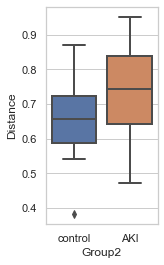

In [44]:
import seaborn as sns
sns.set(rc={'figure.figsize':(2,4)})
sns.set_style("whitegrid")
sns.boxplot(x='Group2', y='Distance', linewidth='2',data=dist2)
plt.savefig('Distance_to_control_Boxplot.pdf', bbox_inches="tight")

#### Cytokine inference analysis

In [98]:
df = pd.read_csv('Disease_comparison_annotated_proteins.csv',index_col='Entry')
Edges_df = pd.read_csv('../../string_interactions_CYTOKINEINFERENCE.txt',sep='\t')
Map_df = pd.read_csv('../../string_mapping_CYTOKINEINFERENCE.tsv',sep='\t',index_col='queryItem')
infered_cytokines = pd.read_csv('../../cytokines_to_infer_list.txt',sep='\t',header=None)
infered_cytokines_list= list(infered_cytokines[0])

In [99]:
cols = ['annotation','preferredName']
Map_df2 = Map_df[cols]
df2 = df.merge(Map_df2, left_index=True,right_index=True, how = 'left')
df2.index = df2['preferredName']

In [100]:
AKI_list = list(df2[df2['AKI/Control pi score']>1].index)
CNTRL_list = list(df2[df2['AKI/Control pi score']<-1].index)

In [101]:
total_list = AKI_list + CNTRL_list

In [102]:
#Edges were pre-filtered to remove connections between cytokines
Node_list = list(Edges_df['#node1'])+list(Edges_df['node2'])

In [103]:
#Generate a dataframe from the counts of each category
from collections import Counter
counts = Counter(Node_list)
countsdf2 = pd.DataFrame.from_dict(counts, orient = 'index')
countsdf2 = countsdf2.rename(index = str, columns={0:"Number of Connections"})

In [105]:
proteinsdf = countsdf2[countsdf2.index.isin(total_list)]

In [106]:
cytokinesdf = countsdf2[countsdf2.index.isin(infered_cytokines_list)]

In [107]:
#Filter out any cytokines less than 4
cytokinesdf2=cytokinesdf[cytokinesdf['Number of Connections']>4]

In [108]:
cytokines_filtered = list(cytokinesdf2.index)

In [110]:
node1=[]
node2=[]
for i in Edges_df['#node1']:
    if i in(AKI_list):
        node1.append('AKI')
    elif i in(CNTRL_list):
        node1.append('CNTRL')
    elif i in(cytokines_filtered):
        node1.append(i)
    else:
        node1.append('Error?')

for i in Edges_df['node2']:
    if i in(AKI_list):
        node2.append('AKI')
    elif i in(CNTRL_list):
        node2.append('CNTRL')
    elif i in(cytokines_filtered):
        node2.append(i)
    else:
        node2.append('Error?')

In [111]:
Edges_df['node1_cat']=node1
Edges_df['node2_cat']=node2

,#node1,node2,Node1 Cytokine?,Node2 Cytokine?,node1_string_internal_id,node2_string_internal_id,node1_external_id,node2_external_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score,node1_cat,node2_cat
0,KRT10,KRT1,NaN,NaN,4435898,4434216,9606.ENSP00000269576,9606.ENSP00000252244,0,0,0.000,0.880,0.147,0.990,0.90,0.890,0.999,CNTRL,CNTRL
1,FGA,FGB,NaN,NaN,4438214,4438190,9606.ENSP00000306361,9606.ENSP00000306099,0,0,0.000,0.744,0.992,0.961,0.90,0.955,0.999,AKI,AKI
2,FGG,FGA,NaN,NaN,4440740,4438214,9606.ENSP00000336829,9606.ENSP00000306361,0,0,0.000,0.764,0.993,0.966,0.90,0.940,0.999,AKI,AKI
3,COL1A2,COL1A1,NaN,NaN,4437383,4433346,9606.ENSP00000297268,9606.ENSP00000225964,0,0,0.443,0.958,0.991,0.454,0.90,0.948,0.999,CNTRL,CNTRL
4,KRT5,KRT14,NaN,NaN,4434215,4432701,9606.ENSP00000252242,9606.ENSP00000167586,0,0,0.000,0.781,0.742,0.991,0.90,0.950,0.999,CNTRL,CNTRL
5,FGG,FGB,NaN,NaN,4440740,4438190,9606.ENSP00000336829,9606.ENSP00000306099,0,0,0.000,0.803,0.992,0.962,0.90,0.938,0.999,AKI,AKI
6,KRT1,KRT5,NaN,NaN,4434216,4434215,9606.ENSP00000252244,9606.ENSP00000252242,0,0,0.000,0.963,0.131,0.976,0.90,0.670,0.997,CNTRL,CNTRL
7,KRT2,KRT1,NaN,NaN,4438640,4434216,9606.ENSP00000310861,9606.ENSP00000252244,0,0,0.000,0.965,0.309,0.953,0.90,0.800,0.996,CNTRL,CNTRL
8,KRT16,KRT5,NaN,NaN,4437781,4434215,9606.ENSP00000301653,9606.ENSP00000252242,0,0,0.000,0.780,0.533,0.910,0.90,0.673,0.996,CNTRL,CNTRL
9,KRT77,KRT10,NaN,NaN,4441276,4435898,9606.ENSP00000342710,9606.ENSP00000269576,0,0,0.000,0.786,0.147,0.955,0.90,0.455,0.996,CNTRL,CNTRL


In [112]:
#Remove edges with errors:
Edges_df2 = Edges_df[Edges_df['node1_cat']!='Error?']
Edges_df2 = Edges_df2[Edges_df2['node2_cat']!='Error?']

Count the number of connections of each cytokine to each category (AKI or CNTRL). Then divide by the total number of connections within the category. Then compare this ratio to the ratio of connections this cytokine has in the entire dataset.

In [118]:
Node1_AKI=Edges_df2[Edges_df2['node1_cat']=="AKI"]
Node1_cytokine_counts=pd.DataFrame.from_dict(Counter(Node1_AKI[Node1_AKI['node2_cat'].isin(cytokines_filtered)]['node2_cat']),orient = 'index')

In [119]:
Node2_AKI=Edges_df2[Edges_df2['node2_cat']=="AKI"]
Node2_cytokine_counts=pd.DataFrame.from_dict(Counter(Node2_AKI[Node2_AKI['node1_cat'].isin(cytokines_filtered)]['node1_cat']),orient = 'index')

In [124]:
df3=Node2_cytokine_counts.merge(Node1_cytokine_counts,left_index=True,right_index=True,how='outer')
df3['AKI_Connections'] = df3.sum(axis=1)

,0_x,0_y,AKI_Connections
CCL1,NaN,1.0,1.0
CCL11,1.0,1.0,2.0
CCL19,1.0,NaN,1.0
CCL2,NaN,2.0,2.0
CCL20,1.0,NaN,1.0
CCL21,1.0,1.0,2.0
CCL27,1.0,NaN,1.0
CCL4,3.0,NaN,3.0
CCL5,1.0,NaN,1.0
CXCL1,2.0,NaN,2.0


In [126]:
Node1_CNTRL=Edges_df2[Edges_df2['node1_cat']=="CNTRL"]
Node1_cytokine_counts=pd.DataFrame.from_dict(Counter(Node1_CNTRL[Node1_CNTRL['node2_cat'].isin(cytokines_filtered)]['node2_cat']),orient = 'index')

Node2_CNTRL=Edges_df2[Edges_df2['node2_cat']=="CNTRL"]
Node2_cytokine_counts=pd.DataFrame.from_dict(Counter(Node2_CNTRL[Node2_CNTRL['node1_cat'].isin(cytokines_filtered)]['node1_cat']),orient = 'index')

df4=Node2_cytokine_counts.merge(Node1_cytokine_counts,left_index=True,right_index=True,how='outer')
df4['CNTRL_Connections'] = df4.sum(axis=1)

,0_x,0_y,CNTRL_Connections
CCL19,2.0,NaN,2.0
CCL2,NaN,2.0,2.0
CCL20,2.0,NaN,2.0
CXCL1,3.0,NaN,3.0
CXCL12,2.0,NaN,2.0
IL13,2.0,NaN,2.0
IL24,1.0,NaN,1.0
IL4,NaN,1.0,1.0
IL6,3.0,NaN,3.0
TNF,2.0,NaN,2.0


In [134]:
#Number of times AKI is connected:
Node1_counts=pd.DataFrame.from_dict(Counter(Edges_df2['node1_cat']),orient = 'index')
Node2_counts=pd.DataFrame.from_dict(Counter(Edges_df2['node2_cat']),orient = 'index')

df5=Node2_counts.merge(Node1_counts,left_index=True,right_index=True,how='outer')
df5['Edge_Counts'] = df5.sum(axis=1)
df5

,0_x,0_y,Edge_Counts
AKI,95.0,75.0,170.0
CCL1,1.0,NaN,1.0
CCL11,1.0,1.0,2.0
CCL19,NaN,3.0,3.0
CCL2,4.0,NaN,4.0
CCL20,NaN,3.0,3.0
CCL21,1.0,1.0,2.0
CCL27,NaN,1.0,1.0
CCL4,NaN,3.0,3.0
CCL5,NaN,1.0,1.0


In [139]:
df5['Prcnt_total']=df5['Edge_Counts']/df5['Edge_Counts'].sum()

In [136]:
df4['CNTRL_Connects_div_edges'] = df4['CNTRL_Connections']/239
df3['AKI_Connects_div_edges'] = df3['AKI_Connections']/170
df6 = df3.merge(df4,left_index=True,right_index=True,how='outer')
df6

,0_x_x,0_y_x,AKI_Connections,AKI_Connects_div_edges,0_x_y,0_y_y,CNTRL_Connections,CNTRL_Connects_div_edges
CCL1,NaN,1.0,1.0,0.005882,NaN,NaN,NaN,NaN
CCL11,1.0,1.0,2.0,0.011765,NaN,NaN,NaN,NaN
CCL19,1.0,NaN,1.0,0.005882,2.0,NaN,2.0,0.008368
CCL2,NaN,2.0,2.0,0.011765,NaN,2.0,2.0,0.008368
CCL20,1.0,NaN,1.0,0.005882,2.0,NaN,2.0,0.008368
CCL21,1.0,1.0,2.0,0.011765,NaN,NaN,NaN,NaN
CCL27,1.0,NaN,1.0,0.005882,NaN,NaN,NaN,NaN
CCL4,3.0,NaN,3.0,0.017647,NaN,NaN,NaN,NaN
CCL5,1.0,NaN,1.0,0.005882,NaN,NaN,NaN,NaN
CXCL1,2.0,NaN,2.0,0.011765,3.0,NaN,3.0,0.012552


In [140]:
df7 = df6.merge(df5,left_index=True,right_index=True)
df7

,0_x_x,0_y_x,AKI_Connections,AKI_Connects_div_edges,0_x_y,0_y_y,CNTRL_Connections,CNTRL_Connects_div_edges,0_x,0_y,Edge_Counts,Prcnt_total
CCL1,NaN,1.0,1.0,0.005882,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.002058
CCL11,1.0,1.0,2.0,0.011765,NaN,NaN,NaN,NaN,1.0,1.0,2.0,0.004115
CCL19,1.0,NaN,1.0,0.005882,2.0,NaN,2.0,0.008368,NaN,3.0,3.0,0.006173
CCL2,NaN,2.0,2.0,0.011765,NaN,2.0,2.0,0.008368,4.0,NaN,4.0,0.008230
CCL20,1.0,NaN,1.0,0.005882,2.0,NaN,2.0,0.008368,NaN,3.0,3.0,0.006173
CCL21,1.0,1.0,2.0,0.011765,NaN,NaN,NaN,NaN,1.0,1.0,2.0,0.004115
CCL27,1.0,NaN,1.0,0.005882,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.002058
CCL4,3.0,NaN,3.0,0.017647,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.006173
CCL5,1.0,NaN,1.0,0.005882,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.002058
CXCL1,2.0,NaN,2.0,0.011765,3.0,NaN,3.0,0.012552,NaN,5.0,5.0,0.010288


In [141]:
df7['Prct_AKI_Edges_div_Prct_Total_Edges']= df7['AKI_Connects_div_edges']/df7['Prcnt_total']
df7['Prct_CNTRL_Edges_div_Prct_Total_Edges']= df7['CNTRL_Connects_div_edges']/df7['Prcnt_total']

In [143]:
df7.to_csv('./Cytokine_inferences.csv')